In [1]:
import os
import tensorflow as tf
from PIL import Image
from nets import nets_factory
import numpy as np
import matplotlib.pyplot as plt

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
number = ['0','1','2','3','4','5','6','7','8','9']
alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
ALPHABET = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

comb1 = number + alphabet
comb2 = number + alphabet + ALPHABET

simple = number + ['a','b','c','g']
print(comb1)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [3]:
CHAR_SET_LEN = len(comb1)    ###############################################
IMAGE_HEIGHT, IMAGE_WIDTH = 60, 100
BATCH_SIZE = 1 
TFRECORD_FILE = 'captcha/test.tfrecords'

x = tf.placeholder(tf.float32,[None,224,224])

def read_and_decode(filename):
    filename_queue = tf.train.string_input_producer([filename])
    reader = tf.TFRecordReader()
    
    # get filenames(labels)
    _, serialized_example = reader.read(filename_queue)
    features = tf.parse_single_example(serialized_example,
                                      features = {
                                      'image': tf.FixedLenFeature([],tf.string),
                                      'label0': tf.FixedLenFeature([],tf.int64),
                                      'label1': tf.FixedLenFeature([],tf.int64),
                                      'label2': tf.FixedLenFeature([],tf.int64),
                                      'label3': tf.FixedLenFeature([],tf.int64) 
                                 })
    

    image = tf.decode_raw(features['image'],tf.uint8)    
    image_raw = tf.reshape(image,[224,224])    
    image = tf.reshape(image,[224,224])    
    image = tf.cast(image,tf.float32) / 255.0
    image = tf.subtract(image,0.5)
    image = tf.multiply(image,2.0)
   
    label0 = tf.cast(features['label0'],tf.int32)
    label1 = tf.cast(features['label1'],tf.int32)
    label2 = tf.cast(features['label2'],tf.int32)
    label3 = tf.cast(features['label3'],tf.int32)

    return image, image_raw, label0, label1, label2, label3

INFO:tensorflow:Restoring parameters from ./captcha/models/crack_captcha.model-5620


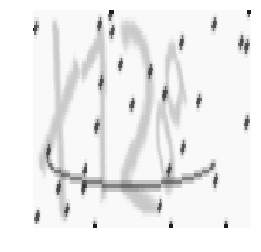

label: x 7 2 g
predict: x 7 2 8


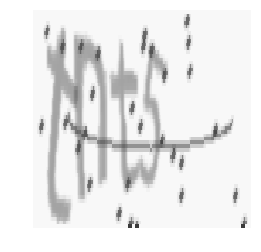

label: t n t 5
predict: t n t 5


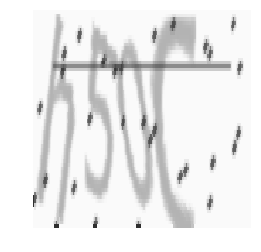

label: h 5 0 c
predict: h 5 o c


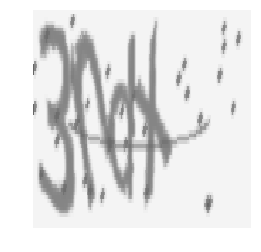

label: 3 n d x
predict: 3 n d x


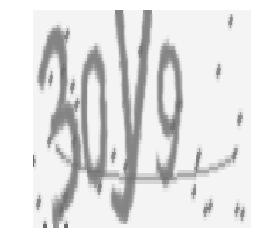

label: 3 o y 9
predict: 3 o y 9


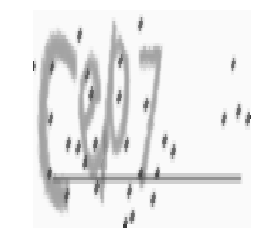

label: c e p 7
predict: c e p 7


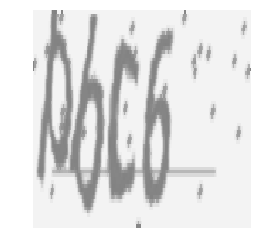

label: p b c 6
predict: p b c 6


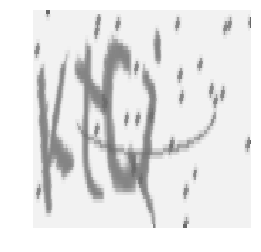

label: k t c i
predict: k t c i


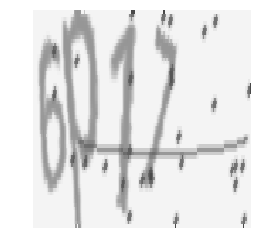

label: 6 p 1 7
predict: 6 p 1 7


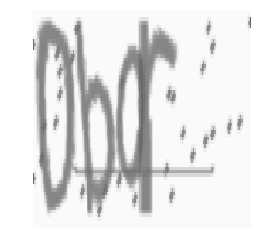

label: 0 b o r
predict: 0 b o r


In [4]:

image, image_raw, label0, label1,label2, label3 = read_and_decode(TFRECORD_FILE)

image_batch, image_raw_batch, label_batch0, label_batch1, label_batch2, label_batch3 = tf.train.shuffle_batch(
    [image, image_raw, label0, label1,label2,label3], batch_size = BATCH_SIZE,
    capacity = 50000, min_after_dequeue = 10000, num_threads = 1)


train_network_fn = nets_factory.get_network_fn(
    'alexnet_v2',
    num_classes = CHAR_SET_LEN,
    weight_decay = 0.0005,
    is_training = False)

with tf.Session() as sess:
    #inputs: a tensor of size[batch_size, height, width,channels]
    X = tf.reshape(x,[BATCH_SIZE, 224, 224, 1])
    
    logits0, logits1, logits2, logits3, end_points = train_network_fn(X)

   
    predict0 = tf.reshape(logits0, [-1, CHAR_SET_LEN])
    predict0 = tf.argmax(predict0,1)
    
    predict1 = tf.reshape(logits1, [-1, CHAR_SET_LEN])
    predict1 = tf.argmax(predict1,1)

    predict2 = tf.reshape(logits2, [-1, CHAR_SET_LEN])
    predict2 = tf.argmax(predict2,1)

    predict3 = tf.reshape(logits3, [-1, CHAR_SET_LEN])
    predict3 = tf.argmax(predict3,1)

    
    sess.run(tf.global_variables_initializer())    
    
    saver = tf.train.Saver()
    saver.restore(sess,'./captcha/models/crack_captcha.model-5620')    
    coord = tf.train.Coordinator()     
    threads = tf.train.start_queue_runners(sess = sess, coord = coord)

    for i in range(10):
        b_image, b_image_raw, b_label0, b_label1, b_label2, b_label3 = sess.run([image_batch,
                                                                    image_raw_batch,
                                                                    label_batch0,
                                                                    label_batch1,
                                                                    label_batch2,
                                                                    label_batch3])
        img = Image.fromarray(b_image_raw[0], 'L')
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        print('label:', comb1[b_label0[0]], comb1[b_label1[0]], comb1[b_label2[0]], comb1[b_label3[0]]) ########################
        label0,label1,label2,label3 = sess.run([predict0,predict1,predict2,predict3], feed_dict = {x:b_image})
        print('predict:',comb1[label0[0]], comb1[label1[0]], comb1[label2[0]], comb1[label3[0]]) ############################

    
    coord.request_stop()    
    coord.join(threads)
